# GAN - MNIST - Pytorch

In [1]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *
from numpy import *
from tqdm import tqdm

/opt/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import torch_utils; importlib.reload(torch_utils)
from torch_utils import *
import torch.nn
import torch.nn.parallel
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision.utils import make_grid

from torch import FloatTensor as FT

In [3]:
bs=64
path = '/data/mnist/'

## MNIST pytorch

In [ ]:
dataloader = DataLoader(datasets.MNIST(path, train=True, download=False, transform=transforms.Compose(
                                    [transforms.ToTensor()])), batch_size=bs, shuffle=False)

## MNIST keras

In [4]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [5]:
sz = len(X_train)
dim = X_train.shape[-1]

In [6]:
X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)

In [7]:
#Pytorch expects tensors to be floats
X_train = X_train.float()
#Normalise the dataset to be between [0,1]
X_train = torch.div(X_train, 255)
#Add channel axis
X_train = X_train.view(sz, 1, dim, dim)

In [8]:
datas = torch.utils.data.TensorDataset(X_train, y_train)

In [9]:
X_train.size()

torch.Size([60000, 1, 28, 28])

In [10]:
dataloader = torch.utils.data.DataLoader(datas, bs, True)

## Parameters

In [11]:
n = len(dataloader)
lr = 0.0002
lvar_size = 100

## Generator

In [34]:
 class GAN_G(nn.Module): 
    
    def __init__(self, lvar):
        super(GAN_G, self).__init__()
        self.input_height = 28
        self.input_width = 28
        self.input_dim = lvar
        self.output_dim = 1
      
        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * (self.input_height // 4) * (self.input_width // 4)),
            nn.BatchNorm1d(128 * (self.input_height // 4) * (self.input_width // 4)),
            nn.ReLU(),
        )
        
        self.upblock1 = nn.Sequential(
            nn.Conv2d(128, 64, 3, 1, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64)
        )
        self.upblock2 = nn.Sequential(
            nn.Conv2d(64, 32, 3, 1, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32)
        )

        self.final = nn.Sequential(
            nn.Conv2d(32, 1, 1, bias=False),
            nn.Sigmoid(),
        )  
    def forward(self, input):
        x = self.fc(input)
        x = x.view(-1, 128, self.input_height//4, self.input_width//4)
        x = F.upsample(x, scale_factor=2)
        x = self.upblock1(x)
        x = F.upsample(x, scale_factor=2)
        x = self.upblock2(x)
        x = self.final(x)
        return x


### Discriminator

In [35]:
class GAN_D(nn.Module):
    def __init__(self):
        super(GAN_D, self).__init__()
        
        self.input_height = 28
        self.input_width = 28
        self.input_dim = 1
        self.output_dim = 1


        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * (self.input_height // 4) * (self.input_width // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
            nn.Sigmoid(),
        )

    def forward(self, input):
        x = self.conv(input)
        x = x.view(-1, 128 * (self.input_height // 4) * (self.input_width // 4))
        x = self.fc(x)

        return x
    

### Weight functions

In [36]:
def weights_init(m):
    if isinstance(m,nn.ConvTranspose2d) | isinstance(m, nn.Conv2d): 
        m.weight.data.normal_(0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

## Training

In [37]:
netG = GAN_G(lvar_size).cuda()
netG.apply(weights_init);

In [38]:
netD = GAN_D().cuda()
netD.apply(weights_init);

In [39]:
def Var(*parms): return Variable(FT(*parms).cuda())

In [40]:
def create_noise(b): 
    return Variable(FT(b, lvar_size).cuda().normal_(0, 1))

In [50]:
# Input placeholder
input = Var(bs, lvar_size)
# Fixed noise used for visualizing images when done
fixed_noise = create_noise(bs)

# The numbers 0 and 1
one = np.array([1]*bs).astype('float32')
one = torch.from_numpy(one).cuda()
one = Variable(one.view(bs, 1))
zero = one * 0

In [42]:
optimizerD = optim.Adam(netD.parameters(), lr = lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr = lr, betas=(0.5, 0.999))

In [43]:
def make_trainable(net, val): 
    for p in net.parameters(): p.requires_grad = val

In [44]:
#Loss function
BCE_loss = nn.BCELoss().cuda()

### Train loop 

In [59]:
def train(niter, first=True):
    gen_iterations = 0
    
    netD.train()
    for epoch in tqdm(range(niter)):
        netG.train()
        
        for iter, (x_, _) in enumerate(dataloader):
            if (x_.size()[0]!=bs): break
            
            make_trainable(netD, True)
            real_ = Variable(x_.cuda())
            optimizerD.zero_grad()
            
            D_real = netD(real_)
            errD_real = BCE_loss(D_real, one)
            
            fake = netG(create_noise(real_.size()[0]))
            D_fake = netD(fake)
            errD_fake = BCE_loss(D_fake, zero)
            
            errD = errD_real + errD_fake
            errD.backward()
            optimizerD.step()

            make_trainable(netD, False)
            optimizerG.zero_grad()
            D_fake = netD(netG(create_noise(bs)))
            errG = BCE_loss(D_fake, one)
            errG.backward()
            optimizerG.step()
            gen_iterations += 1
            if (gen_iterations % 1000 == 0):
                print('[%d/%d][%d/%d] Loss_D: %f Loss_G: %f Loss_D_real: %f Loss_D_fake %f' % (
                 epoch, niter, gen_iterations, n,
                 errD.cpu().data.numpy(), errG.cpu().data.numpy(), errD_real.cpu().data.numpy(), errD_fake.cpu().data.numpy()))

### Test

In [60]:
%time train(10)

 10%|█         | 1/10 [00:13<02:00, 13.36s/it]

[1/10][1000/938] Loss_D: 1.043292 Loss_G: 1.062814 Loss_D_real: 0.530286 Loss_D_fake 0.513006


 20%|██        | 2/10 [00:26<01:47, 13.38s/it]

[2/10][2000/938] Loss_D: 0.909419 Loss_G: 1.294614 Loss_D_real: 0.496013 Loss_D_fake 0.413406


 30%|███       | 3/10 [00:40<01:33, 13.36s/it]

[3/10][3000/938] Loss_D: 1.091382 Loss_G: 1.179565 Loss_D_real: 0.519426 Loss_D_fake 0.571956


 40%|████      | 4/10 [00:53<01:20, 13.34s/it]

[4/10][4000/938] Loss_D: 0.870259 Loss_G: 1.233692 Loss_D_real: 0.345165 Loss_D_fake 0.525094


 50%|█████     | 5/10 [01:06<01:06, 13.33s/it]

[5/10][5000/938] Loss_D: 0.925918 Loss_G: 1.148739 Loss_D_real: 0.519079 Loss_D_fake 0.406839


 60%|██████    | 6/10 [01:20<00:53, 13.36s/it]

[6/10][6000/938] Loss_D: 1.104393 Loss_G: 1.233653 Loss_D_real: 0.611877 Loss_D_fake 0.492516


 70%|███████   | 7/10 [01:33<00:40, 13.39s/it]

[7/10][7000/938] Loss_D: 0.782840 Loss_G: 1.151403 Loss_D_real: 0.406761 Loss_D_fake 0.376079


 80%|████████  | 8/10 [01:47<00:26, 13.42s/it]

[8/10][8000/938] Loss_D: 0.879758 Loss_G: 1.366354 Loss_D_real: 0.511042 Loss_D_fake 0.368715


 90%|█████████ | 9/10 [02:00<00:13, 13.42s/it]

[9/10][9000/938] Loss_D: 0.935090 Loss_G: 1.389678 Loss_D_real: 0.401375 Loss_D_fake 0.533715


100%|██████████| 10/10 [02:14<00:00, 13.43s/it]

CPU times: user 2min, sys: 13.7 s, total: 2min 13s
Wall time: 2min 14s


In [51]:
fake = netG(fixed_noise).data.cpu()

In [52]:
%matplotlib inline
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

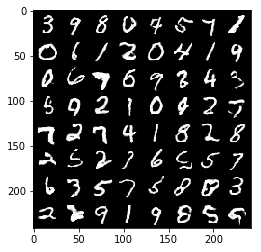

In [53]:
show(torchvision.utils.make_grid(fake))